In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor, as_completed
from threading import Lock
from tqdm import tqdm
import pandas as pd
import logging
import os
from glob import glob
from worker_utils import _worker_standalone

In [2]:
# Define the path to the 'demos' folder
DEMOS_FOLDER = os.path.join(os.path.dirname(''), "..", "demos")

ASSETS_FOLDER = os.path.join(os.path.dirname(''), "..", "assets")
MAPS_BACKGROUND_FOLDER = os.path.join(ASSETS_FOLDER, "maps_background")

# Load all demos paths
demos_paths = glob(os.path.join(DEMOS_FOLDER, "**", "*.dem"), recursive=True)
print(f"Found {len(demos_paths)} demo files. Listing first 5: {demos_paths[:5]}")

# Load all map background images paths
maps_background_paths = {f.split('.')[0]: os.path.join(MAPS_BACKGROUND_FOLDER, f) for f in os.listdir(MAPS_BACKGROUND_FOLDER) if f.endswith('.png')}

Found 101 demo files. Listing first 5: ['../demos/natus-vincere-vs-imperial-nuke.dem', '../demos/91028/natus-vincere-vs-spirit-m2-mirage.dem', '../demos/91028/natus-vincere-vs-spirit-m1-dust2.dem', '../demos/91795/natus-vincere-vs-mouz-m2-dust2.dem', '../demos/91795/natus-vincere-vs-mouz-m3-mirage.dem']


In [3]:
def clean_demos_safe(demos_paths, max_workers=5, verbose=False):
    """
    Safer clean_demos:
    - Always returns (DataFrame, list)
    - Does not remove files automatically
    - Thread-safe and efficient
    """
    if verbose:
        logging.basicConfig(level=logging.INFO)

    dfs, wrong = [], []
    lock = Lock()

    with tqdm(total=len(demos_paths), desc="Cleaning Demos") as progress_bar:
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            futures = {ex.submit(_worker_standalone, p): p for p in demos_paths}
            for fut in as_completed(futures):
                try:
                    df_part, wrong_part = fut.result()
                    if not df_part.empty:
                        dfs.append(df_part)
                    if wrong_part:
                        wrong.extend(wrong_part)
                except Exception as e:
                    logging.error(f"Erro num processo: {e}")
                finally:
                    progress_bar.update(1)

    wrong = list(dict.fromkeys(wrong))  # deduplicate
    final_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return final_df, wrong

final_df, wrong_demos = clean_demos_safe(demos_paths, max_workers=10, verbose=True)
df = final_df.copy()

Cleaning Demos: 100%|██████████| 101/101 [05:59<00:00,  3.56s/it]


In [4]:
final_df

,round_winner,round_reason,team_ct_name,team_t_name,team_ct_players,team_t_players,team_ct_current_equip_value,team_t_current_equip_value,round,map_name
0,2,9,CT,TERRORIST,"[76561198150673360, 76561198193174134, 7656119...","[76561198246607476, 76561198176878303, 7656119...",4150,4800,1,de_dust2
1,2,1,CT,TERRORIST,"[76561198150673360, 76561198193174134, 7656119...","[76561198246607476, 76561198176878303, 7656119...",9900,19850,2,de_dust2
2,2,1,CT,TERRORIST,"[76561198150673360, 76561198193174134, 7656119...","[76561198246607476, 76561198176878303, 7656119...",2950,20650,3,de_dust2
3,3,8,CT,TERRORIST,"[76561198150673360, 76561198193174134, 7656119...","[76561198246607476, 76561198176878303, 7656119...",27500,27350,4,de_dust2
4,2,9,CT,TERRORIST,"[76561198150673360, 76561198193174134, 7656119...","[76561198246607476, 76561198176878303, 7656119...",29000,26550,5,de_dust2
...,...,...,...,...,...,...,...,...,...,...
2147,3,8,CT,TERRORIST,"[76561198355739212, 76561198138828475, 7656119...","[76561198050250233, 76561199063068840, 7656119...",29750,27450,26,de_inferno
2148,3,8,CT,TERRORIST,"[76561198355739212, 76561198138828475, 7656119...","[76561198050250233, 76561199063068840, 7656119...",30550,28450,27,de_inferno
2149,3,8,CT,TERRORIST,"[76561198050250233, 76561199063068840, 7656119...","[76561198355739212, 76561198138828475, 7656119...",28450,27550,28,de_inferno
2150,3,7,CT,TERRORIST,"[76561198050250233, 76561199063068840, 7656119...","[76561198355739212, 76561198138828475, 7656119...",30400,24900,29,de_inferno


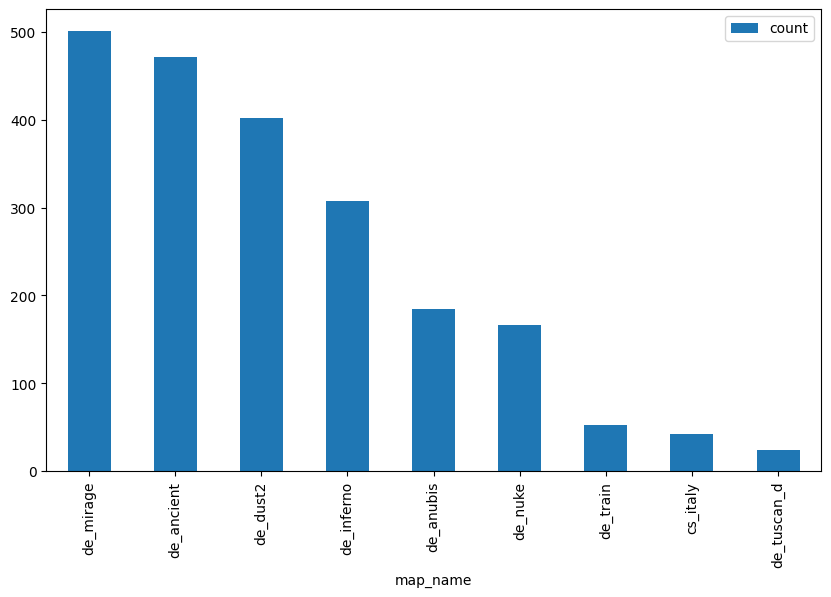

In [5]:
# Show graph that shows the number of demos per map
import pandas as pd
import matplotlib.pyplot as plt

maps_df = df['map_name'].value_counts().reset_index()
maps_df.plot(x='map_name', y='count', kind='bar', figsize=(10, 6))
plt.show()

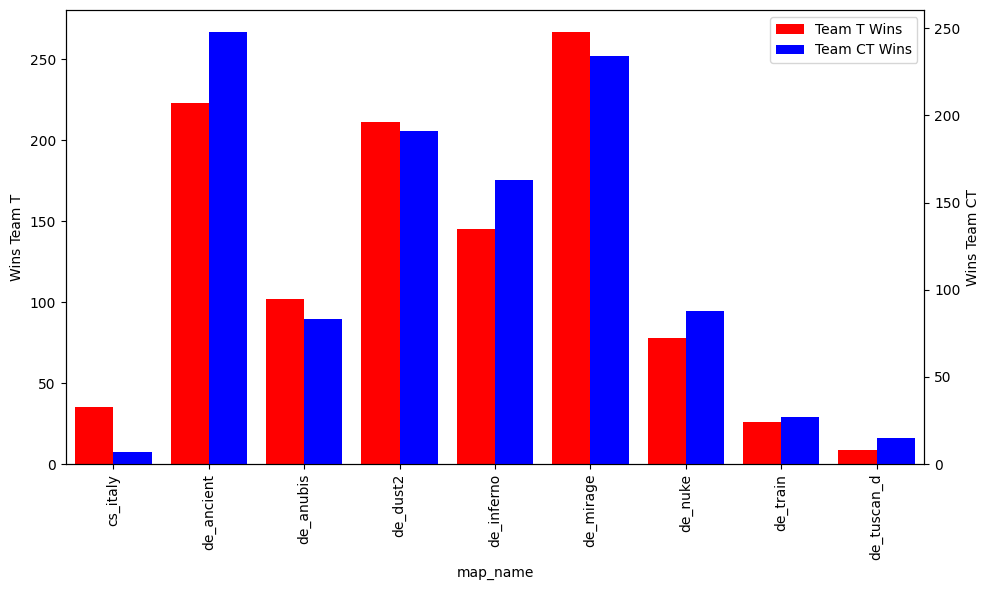

In [6]:
wins_of_team_2 = df[df['round_winner'] == 2].groupby('map_name').size().reset_index(name='wins_of_team_T') # T
wins_of_team_3 = df[df['round_winner'] == 3].groupby('map_name').size().reset_index(name='wins_of_team_CT') # CT
wins_per_team = wins_of_team_2.merge(wins_of_team_3, on='map_name', how='outer')

import matplotlib.pyplot as plt

# 1. Criar o primeiro eixo
fig, ax1 = plt.subplots(figsize=(10, 6))

# 2. Desenhar a primeira barra no ax1
wins_per_team.plot(x='map_name', y='wins_of_team_T', kind='bar', 
                   ax=ax1, position=1, width=0.4, color='red', label='Team T Wins')

# 3. Criar o segundo eixo (que partilha o mesmo X)
ax2 = ax1.twinx()

# 4. Desenhar a segunda barra no ax2
wins_per_team.plot(x='map_name', y='wins_of_team_CT', kind='bar', 
                   ax=ax2, position=0, width=0.4, color='blue', label='Team CT Wins')

# Pedir ao ax1 e ax2 as suas respetivas legendas (handles) e nomes (labels)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax2.get_legend().remove()

# Ajustes de estética
ax1.set_ylabel('Wins Team T')
ax2.set_ylabel('Wins Team CT')
ax1.set_xlim(-0.5, len(wins_per_team)-0.5) # Garante que as barras não saem do gráfico
plt.tight_layout()
plt.show()